# Predict labels of images using neural nets

## Data source

 * Data source are files `train.csv` and `evaluate.csv`.
 * It's 32x32 pixels with black and white values from [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * File `train.csv` contains training data. It's a big file with over 50.000 images.
 * Predicted value is **label**.
 * File `evaluate.csv` contains testing data without label.

## Goal

Try out multiple machine learning models to train and reduce dimensions. Optimize hyperparameters and pick the best model to predict labels in  `evaluate.csv`.

Create a new file `results.csv` with an output of the following format:
```
ID,label
0,0
1,1
...
```


In [234]:
import pandas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from collections import defaultdict
from typing import Type
from sklearn.svm import SVC
from scipy import optimize
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as patches
import torch
from torch.utils.data import TensorDataset
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import time
from datetime import datetime
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor, as_completed
import traceback


def log_print(text: str):
    print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), text)
    
random_seed = 11


# Analysis of the data

First we'll load the data with pandas to understand how it looks like and what the distributions are.

In [2]:
### odtud už je to Vaše

df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Columns: 1025 entries, pix1 to label
dtypes: int64(1025)
memory usage: 410.6 MB


In [3]:
df.describe()


,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024,label
count,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,...,52500.00000,52500.000000,52500.000000,52500.000000,52500.000000,52500.00000,52500.000000,52500.000000,52500.000000,52500.000000
mean,0.883333,0.883333,0.883333,0.883333,0.883333,0.883410,0.883467,0.883695,0.884686,0.887162,...,0.90499,0.906686,0.899943,0.889219,0.884171,0.88341,0.883352,0.883333,0.883333,4.498476
std,1.506764,1.506764,1.506764,1.506764,1.506764,1.506871,1.506957,1.507379,1.512250,1.542576,...,1.94179,2.065057,1.859559,1.594743,1.510982,1.50701,1.506784,1.506764,1.506764,2.874794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,7.000000
max,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,27.000000,66.000000,...,207.00000,206.000000,122.000000,93.000000,24.000000,11.00000,11.000000,11.000000,11.000000,9.000000


We have columns containing pixels in greyscale from 0 to 255. Each picture has 32x32 dimensions, which is together 1024 pixels.

Our dataset is really massive, with 52500 pictures. We'll have to carefully choose our models, so the training can be done in a timely fashion.

We have no missing pixel values, with pixels being predominantly value 0 (white)

Let's analyze our label values now.

In [8]:
df["label"].value_counts()

label
9    5324
2    5284
0    5281
5    5274
4    5260
3    5245
6    5234
1    5207
7    5198
8    5193
Name: count, dtype: int64

We have 10 categories to predict from 0 to 9, evenly distributed, assuming that it'll be t-shirt, trouser, ... from the MNIST dataset. 

Let's find out what each label actually is.

### Drawing pictures, what label is what

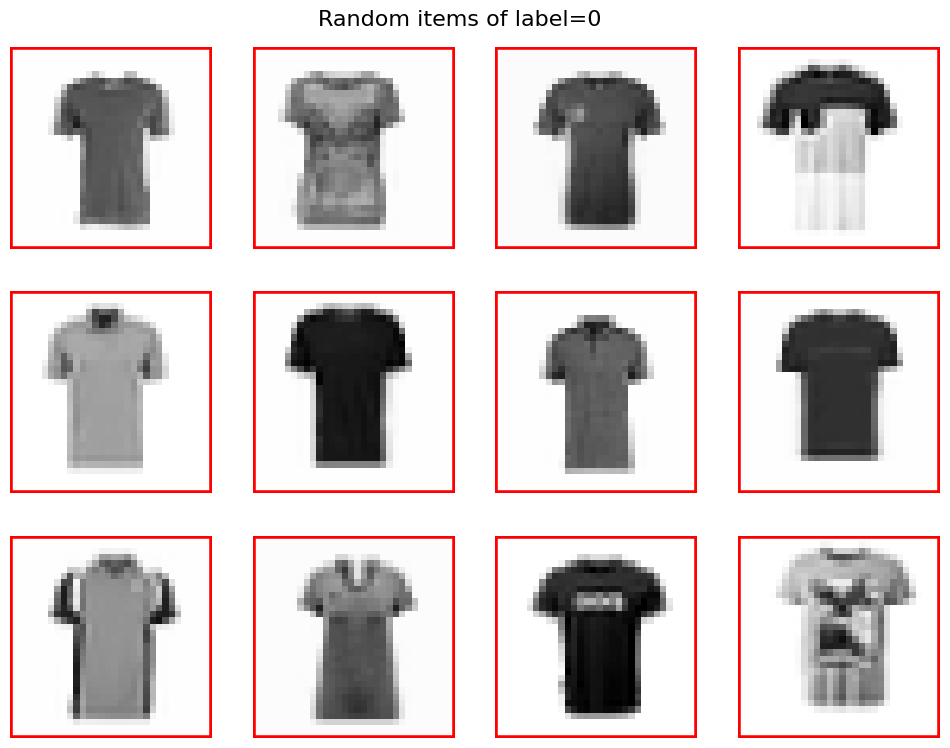

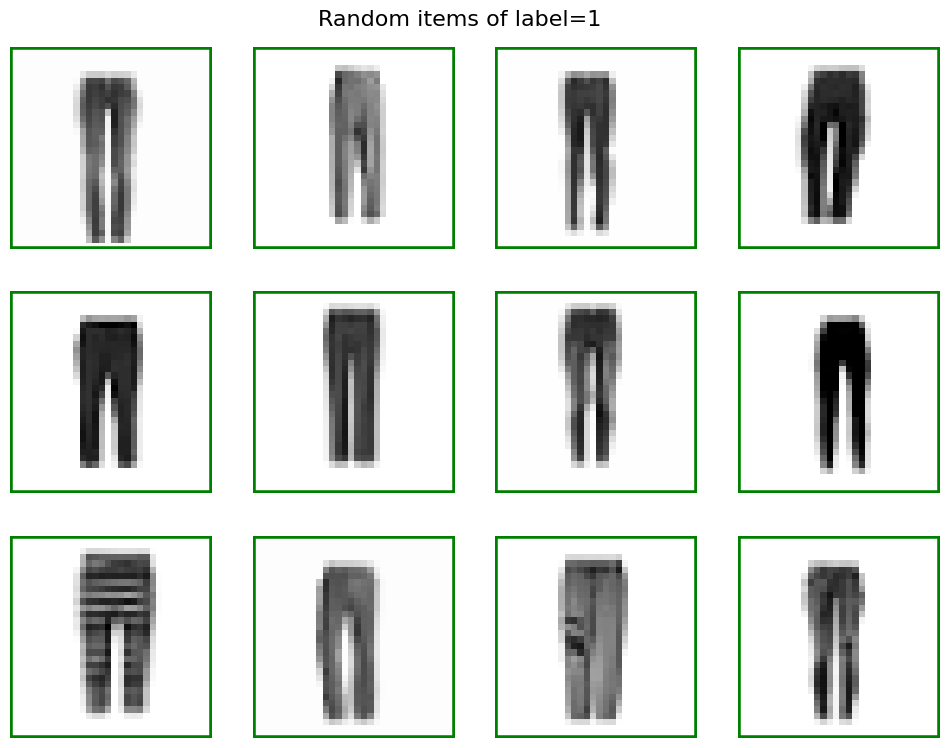

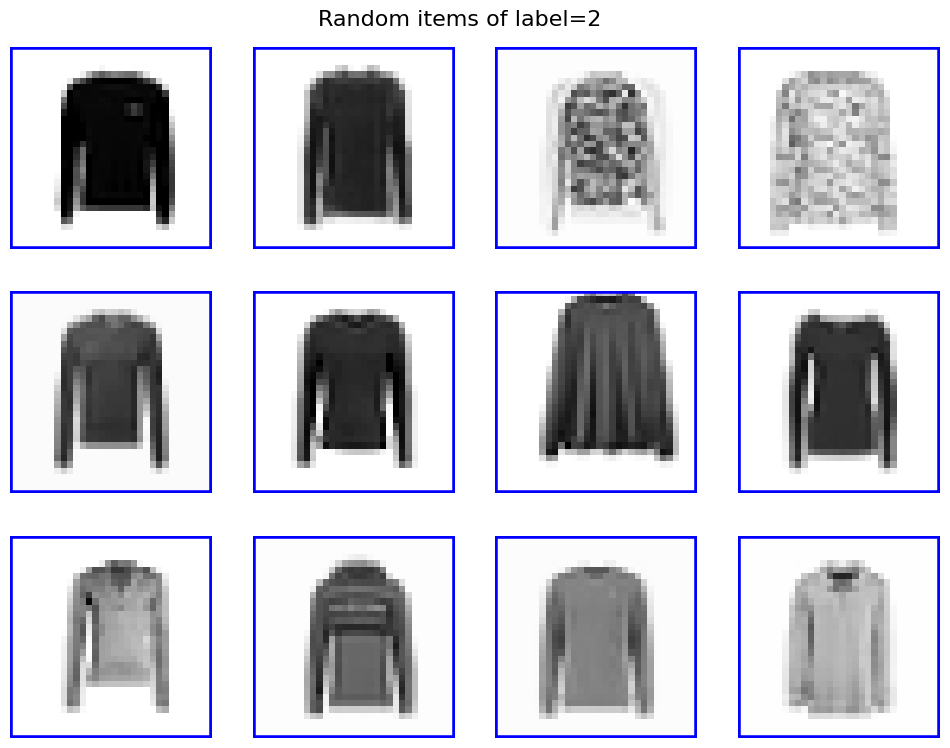

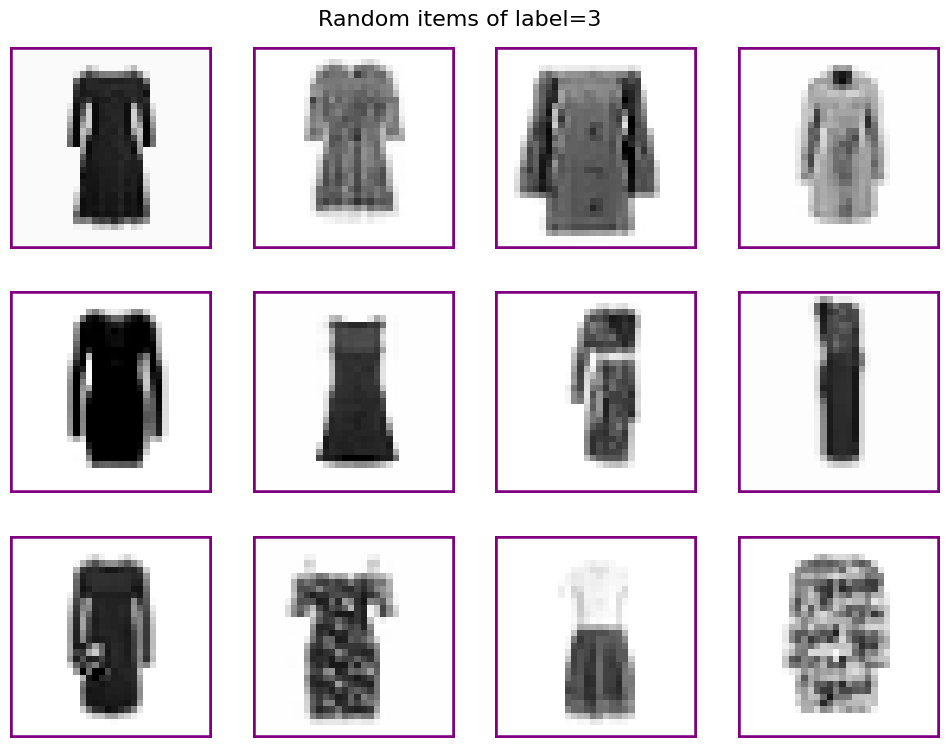

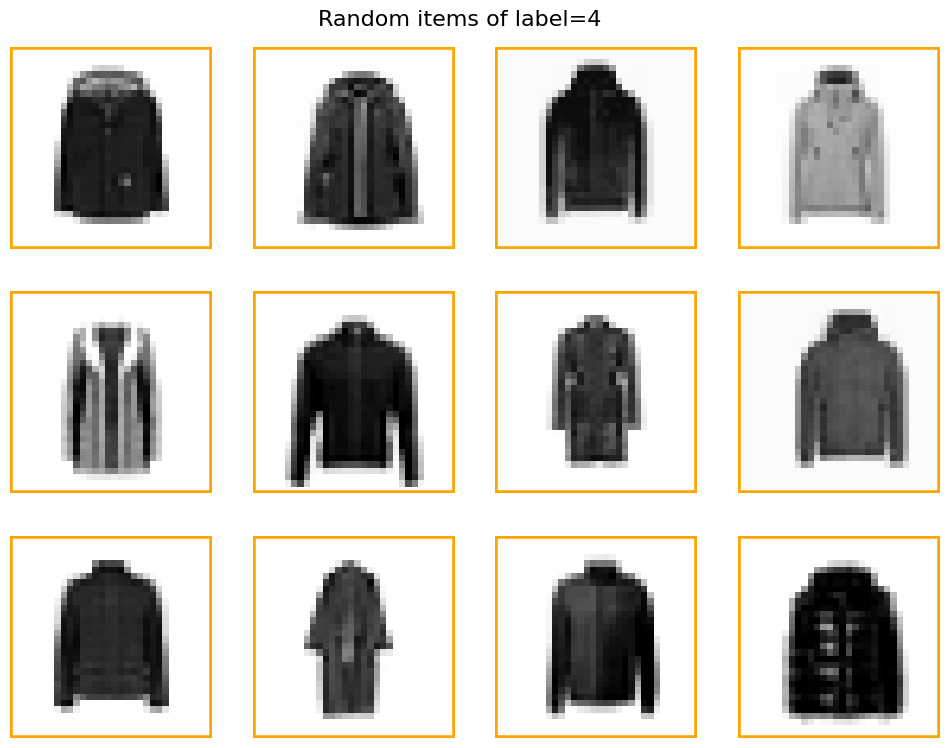

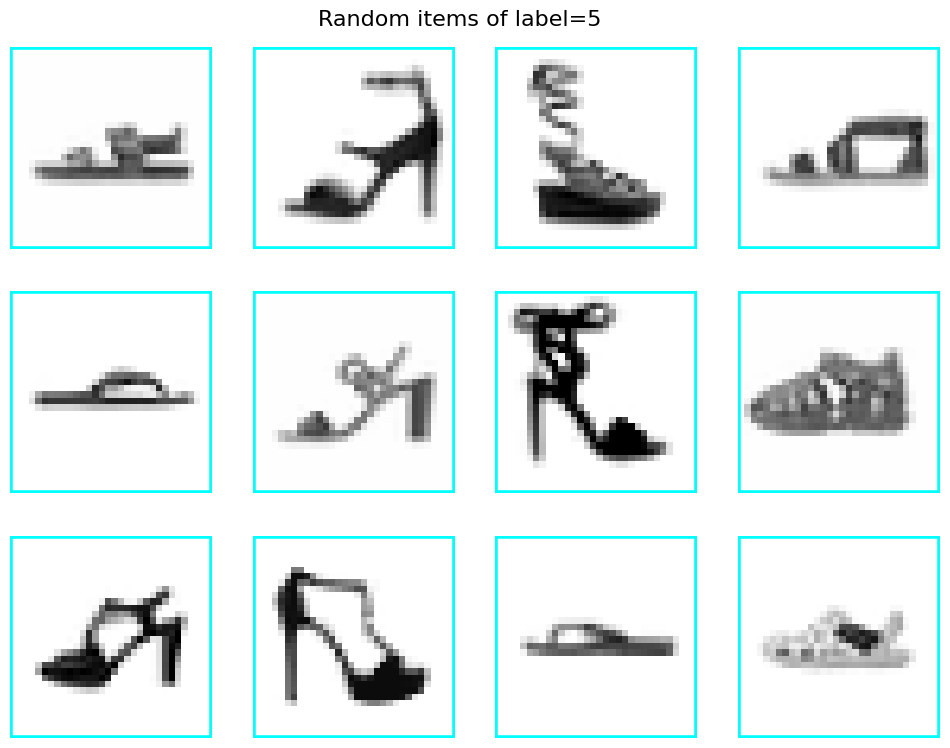

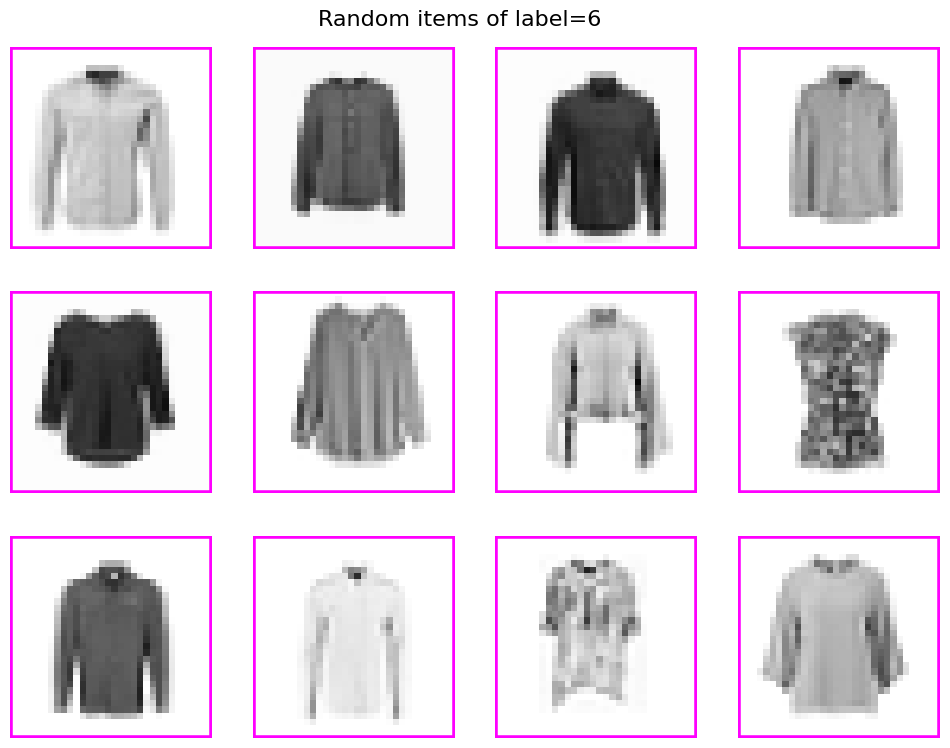

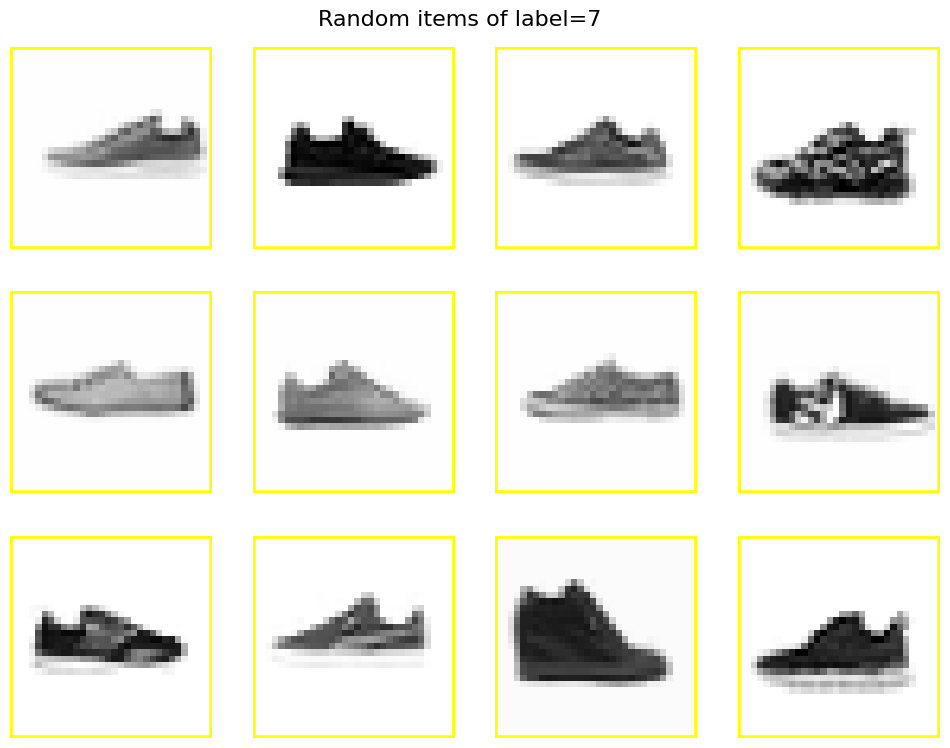

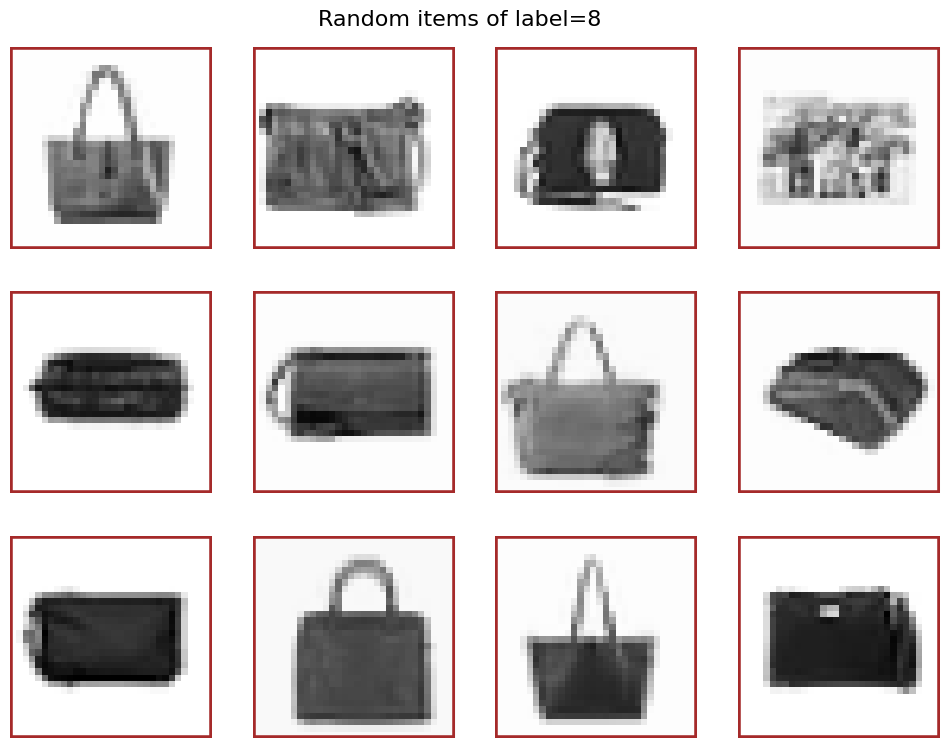

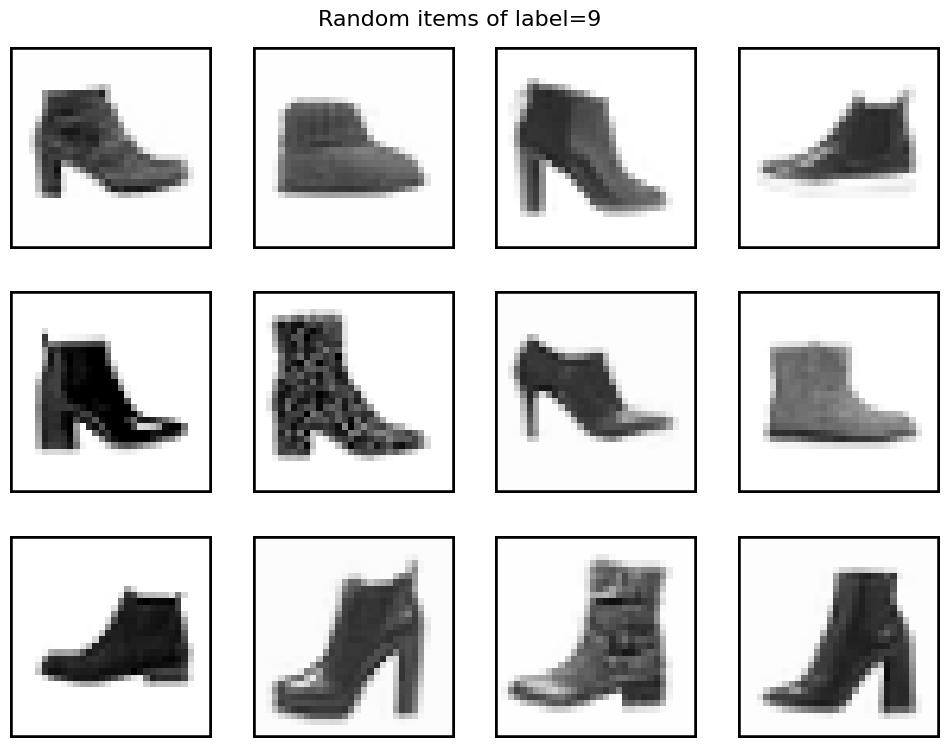

In [9]:

label_colors = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'purple',
    4: 'orange',
    5: 'cyan',
    6: 'magenta',
    7: 'yellow',
    8: 'brown',
    9: 'black'
}

def draw_grid(image_ids: list[int], label: int):
    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    for ax, idx in zip(axes.flatten(), image_ids):
        picture = df.drop(columns=['label']).iloc[idx].values.reshape(32, 32)
        ax.imshow(picture, cmap='gray_r', interpolation='nearest', vmin=0, vmax=255)
        ax.axis('off')

        rect = patches.Rectangle(
            (0, 0), 1, 1, transform=ax.transAxes,
            linewidth=4, edgecolor=label_colors[label], facecolor='none'
        )
        ax.add_patch(rect)

    plt.suptitle(f"Random items of label={label}", fontsize=16, y=0.92)
    plt.show()

for label in range(10):
    sample_df = df[df["label"] == label].sample(n=12, random_state=random_seed)
    draw_grid(sample_df.index.tolist(), label)

It looks like the labels exactly correspond to the MNIST data, with:
- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

There's one potential problem with these labels. We have label 0 of T-shirt/top and label 6 of shirt. They are quite similar to each other, and I can't tell the difference. This could be an issue while predicting.

With labels being so similar to the Fashion MNIST data, why is our dataset 32x32, but MNIST is 28x28?
Do we have some unnecessary pixels that we can remove?
Let's investigate individual pixel values now.

In [10]:
non_zero_counts = df.drop(columns=['label']).apply(lambda col: (col == 0).sum()).sort_values()

print(non_zero_counts)
print("avg:", round(non_zero_counts.mean(), 2))
print("median:", round(non_zero_counts.median(), 2))

pix627       913
pix595       924
pix622       943
pix590       970
pix594      1060
           ...  
pix929     33621
pix961     33621
pix992     33621
pix994     33621
pix1024    33621
Length: 1024, dtype: int64
avg: 22670.15
median: 26706.5


There are no pixels that are 0s for every image. I've found out that 32 pixels have exactly 33621 0s, which is unusual, but nothing that we can use.

My assumption was, that those added 4x4 images were added as a background, which may still be true, but we can't just remove them. We also don't know which pixels are significant, and which are just a background. We'll just work with all the pixels and won't remove any.
 

In [11]:
value_frequencies = df.drop(columns=['label']).stack().value_counts()
print(value_frequencies)
print("all pixels:", 52500 * 1024)
print("median:", value_frequencies.median())

0      23214234
1       4812737
2       3450197
3       2181096
4       1353756
         ...   
250       31019
251       28865
252       26409
253       24840
254       23696
Name: count, Length: 256, dtype: int64
all pixels: 53760000
median: 62875.0


All pixel values appear at least at some images, with the most common pixel values being:
 - 0 - 43.2% of dataset
 - 1 - 9% of dataset
 - 2 - 6.4% of dataset

Least common pixel values:
 - 254 - 0.04% of dataset
 - 253 - 0.05% of dataset

This tells us that 0 values are dominating the dataset, with lesser pixel values being more common (probably background), and higher pixel values (closer to black) are less common. This trend is generally true, with exception being 255, which is 8th most common pixel value.

# Applying models

Now we're going to split data into train, validation and test data, and train Neural Networks. Firstly we'll do Multilayer Perceptron neural networks, and then Convolutional neural networks. We're going to compare which performs better.

## Converting the data

We're splitting the data into train, validation and test data with common ratios. Train will be used for training the Neural networks and validation to optimize hyperparameters.

In [4]:
# Split the training dataset into 60% train and 40% rest
Xtrain, Xrest, Ytrain, yrest = train_test_split(
    df.drop(columns=['label']), df.label, test_size=0.4, random_state=random_seed
)

# Split the rest of the data into 0.6*0.4=24% validation, 0.4*0.4=16% test
Xtest, Xval, Ytest, Yval = train_test_split(
    Xrest, yrest, test_size=0.6, random_state=random_seed
)

print("Num of train rows:", len(Xtrain))
print("Num of val rows:", len(Xval))
print("Num of test rows:", len(Xtest))


Num of train rows: 31500
Num of val rows: 12600
Num of test rows: 8400


Next we convert the pandas Dataframes into tensor datasets. These tensors are optimized for neural networks and GPU heavy calculations. We'll work with torch.dataset from now on.

In [5]:
def convert_to_tensor_dataset(X: pd.DataFrame, Y: pd.Series) -> TensorDataset:
    pixel_tensor = torch.tensor(
        X.values, dtype=torch.float32
    ).reshape(-1, 1, 32, 32)
    
    label_tensor = torch.tensor(Y.values, dtype=torch.long)
    
    return TensorDataset(pixel_tensor, label_tensor)


train_dataset = convert_to_tensor_dataset(Xtrain, Ytrain)
val_dataset = convert_to_tensor_dataset(Xval, Yval)
test_dataset = convert_to_tensor_dataset(Xtest, Ytest)


Let's print some random images to verify if our conversion to dataset was successful.

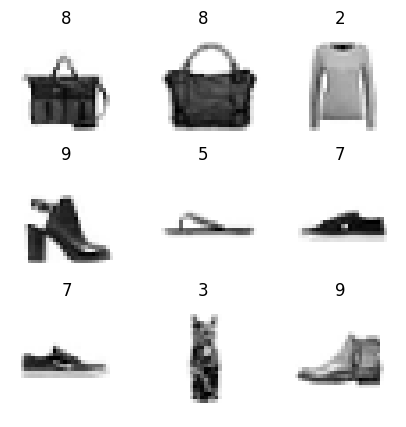

In [14]:
figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, label = train_dataset[i]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{label}")
    plt.axis("off")
    plt.imshow(img[0,:,:], cmap="gray_r")
plt.show()

## Multilayer Perceptron neural networks

Now it's time to train the model. First, we'll use multilayer perceptron neural networks. They're really good with remembering complex patterns. It consists of multiple hidden layers with different sizes, each calculating weights by matrix multiplications. In each hidden layer, we'll get rid of linearity with activation function. We'll mostly use RELU, which just gets rid of all negative values, ensuring that our model won't collapse into linear. The final layer of our model will give us the values for 10 labels (logits). The highest value means that it's that label with the highest probability.

The neural networks class has configurable network depth and sizes.

The activation functions that we'll try (later) will be:
RELU - max(0, z) - don't allow negative values
Leaky RELU - 0.01 * x if x < 0 else x
SELU - exponentially scale negative values

We also added dropout and batch_norm, we'll talk about it later.


In [210]:

IMAGE_SIZE = 1024
LABELS_NUM = 10

class NeuralNetworks(nn.Module):
    
    def __init__(self, hidden_sizes: list[int], activation_function=nn.ReLU, dropout: float = 0.0, batch_norm: bool=False):
        super().__init__()
        layers = []

        in_features = IMAGE_SIZE
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(activation_function())
            if dropout > 0:
                layers.append(nn.Dropout(p=dropout))
            in_features = hidden_size

        layers.append(nn.Linear(in_features, LABELS_NUM))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        return self.net(x)

We also created a function to train 1 epoch. Epoch means going over every dataset once. 

We have a data loader, which loads data in configurable amount of batches (512). 

For each batch of data, we:
1. update model's weights - forward pass
2. calculate the accuracy of our guesses with loss function
3. and based on the loss function we calculate the best way to maximize the correctness (based on gradient).
4. optimizer updates weights to maximize the corectness - backpropagation 

In [7]:

def train_one_epoch(model: nn.Module, loss_function, optimizer, data_loader: DataLoader) -> float:
    running_cum_loss = 0
    
    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        last_mean_loss = loss.item()
        running_cum_loss += last_mean_loss * inputs.shape[0]

    epoch_error = running_cum_loss / len(data_loader.dataset)
    return epoch_error


Let's now try running just 1 epoch.

In [9]:
neural_networks_model = NeuralNetworks([256, 128])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(neural_networks_model.parameters(), lr=0.001)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=5
)

epoch_error = train_one_epoch(neural_networks_model, criterion, optimizer, train_dataloader)
print(f"Finished epoch with training error: {epoch_error:.3f}")


parameters: <generator object Module.parameters at 0x7f499a5999a0>
Finished epoch with training error: 1.074


Next we try 10 predictions on validation data. We always take the label of maximal value of logits returned by the model, that's the most likely label.

In [18]:
neural_networks_model.eval()

with torch.no_grad():
    i = 0
    predicted_labels = []
    actual_labels = []
    for inputs, labels in val_dataset:
        outputs = neural_networks_model(inputs) 
        predictions = torch.argmax(outputs, dim=1)

        predicted_labels += predictions.tolist()
        actual_labels.append(labels.tolist())
        
        if i > 10:
            break
        i += 1
        
    print("Predicted labels:", predicted_labels)
    print("True labels     :", actual_labels)

Predicted labels: [4, 9, 9, 2, 5, 8, 7, 0, 5, 2, 3, 0]
True labels     : [4, 9, 9, 2, 5, 8, 7, 0, 7, 4, 3, 0]


We see that most of our predictions were correct, 8/10 after only 1 epoch. That probably means that our model is correct.

## Optimizing hyperparameters
Next we're creating a function to validate our predictions. We'll first train our model on the training data, and then calculate it's accuracy on validation data. We'll try multiple different configurations of the model, and then decide which has the best accuracy.

In [118]:

def validate_model(model: nn.Module, val_dataloader: DataLoader, device=None):
    model.train(False)
    
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            if device:
                inputs = inputs.to(device)
                labels = labels.to(device)
            # get logits - prediction scores for each class, the highest value is the most likely label
            model_outputs = model(inputs)
            # the best prediction out of 10 labels
            model_predictions = torch.argmax(model_outputs, dim=1)

            # array of true / false whether we had a match or not
            prediction_matches = model_predictions == labels
            correct_predictions += prediction_matches.sum()
            total_predictions += len(prediction_matches)

    model.train(True)
    return correct_predictions / total_predictions
                    

In [ ]:
val_dataloader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=5
)


In [ ]:
accuracy = validate_model(neural_networks_model, val_dataloader)
print("accuracy:", accuracy)

As we can see, our accuracy wasn't the best for a single epoch. We're going to try multiple epochs (go over the data multiple times), and multiple depths. We're going to view the relationship between increasing depths and epochs.

In [38]:
import time

max_epochs = 50

depths = [[256] * i for i in range(2, 10)]

results = []

start_all = time.time()
for depth in depths:
    start = time.time()

    neural_networks_model = NeuralNetworks(depth)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(neural_networks_model.parameters(), lr=0.001)

    for epoch in range(max_epochs):
        epoch_error = train_one_epoch(neural_networks_model, criterion, optimizer, train_dataloader)
        accuracy_score = validate_model(neural_networks_model)
        
        results.append({
            "depth": len(depth),
            "epoch": epoch + 1,
            "accuracy": accuracy_score
        })

    print("Depth:", len(depth), "took:", f"{(time.time() - start):.3f}")
            
best_hyperparameters = max(results, key=lambda x: x["accuracy"])
print("best hyperparameters:", best_hyperparameters)
print("Took overall:", f"{(time.time() - start_all):.3f}")


Depth: 2 took: 174.468
Depth: 3 took: 191.793
Depth: 4 took: 204.601
Depth: 5 took: 218.345
Depth: 6 took: 235.998
Depth: 7 took: 244.142
Depth: 8 took: 256.051
Depth: 9 took: 278.914
best hyperparameters: {'depth': 2, 'epoch': 17, 'accuracy': tensor(0.7877)}
Took overall: 1804.316


We have an issue, training of our model took too long. It takes more than 200 seconds to try each hyperparameter, that's not very good. We won't have a chance to try many of them this way. We must find a better way.

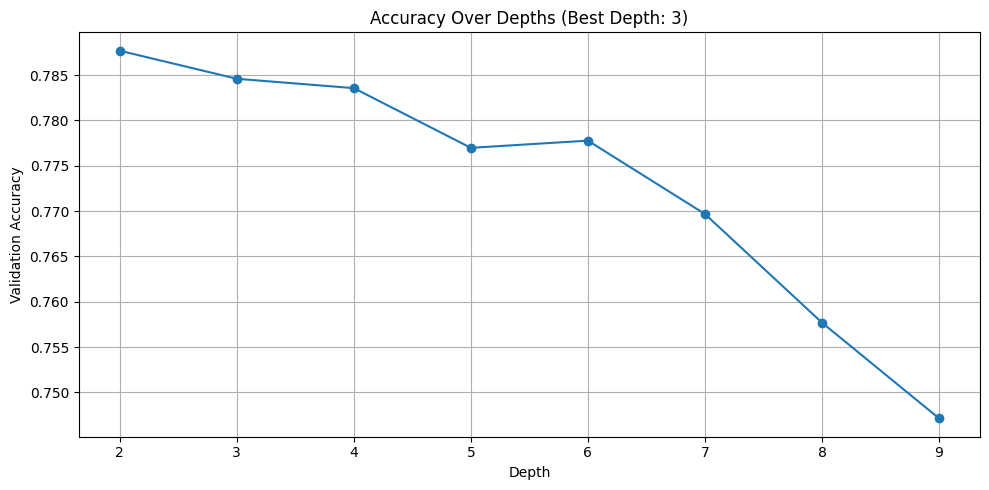

In [39]:
best_depths = defaultdict(float)

for result in results:
    depth = result["depth"]
    accuracy = float(result["accuracy"])
    
    if accuracy > best_depths[depth]:
        best_depths[depth] = accuracy
        
plt.figure(figsize=(12, 6))
plt.plot(best_depths.keys(), best_depths.values(), marker="o")
plt.set_title(f"Accuracy Over Depths (Best Depth: 3)")
plt.set_xlabel("Depth")
plt.set_ylabel("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

As we can see, the accuracy decreases with depth. We haven't experimented with different sizes of neurons yet, but at least we know not to try crazy deep depths. This task is probably too simple for many layers. We would risk overfitting. 

(best depth on the graph should've been 2, there was a slight error)


### Optimizing speed
I've tried many things to optimize the speed. I've tried using Google collabs with A100 GPU, but it didn't support multiprocessing. The training was a bit faster, but nothing too good. I need to train multiple hyperparameters at the same time to improve the speed.

Then I had the idea of renting a VM with multiple GPUs, that would allow multiprocessing. I did so, but unfortunatelly jupyter notebook doesn't support multiprocessing with spawn mode. Cuda does require spawn mode to work. It would work only if I created a python script and ran it outside of the notebook. 

I've also tried to experiment with multithreading, but that wasn't effective at all, since Python's GIL was blocking multiple operations at the same time, which lead to decreased performance.

In the end I ended up with sequential optimizing of hyperparameters. I installed cuda extensions on the VM and put training on GPU. I increased batch size of the loader to 512 (bigger sizes lead to worse accuracy) and set pin memory to use more of the GPU. I was still underutilizing the machine big time, but at least it lead to some improvement. You can see the improvement code below.

In [177]:

def train_one_epoch_cuda(model: nn.Module, loss_function, optimizer, data_loader: DataLoader, device=None, loss_alpha=0.0) -> float:
    running_cum_loss = 0

    model.train(True)

    for inputs, labels in data_loader:
        if device:
            inputs = inputs.to(device)
            labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # optional L1 regularization
        if loss_alpha:
            final_linear_layer = model.net[-1]
            l1_norm = torch.norm(final_linear_layer.weight, p=1)
            loss = loss + loss_alpha * l1_norm
        
        loss.backward()
        optimizer.step()

        last_mean_loss = loss.item()
        running_cum_loss += last_mean_loss * inputs.shape[0]

    model.train(False)
    epoch_error = running_cum_loss / len(data_loader.dataset)
    return epoch_error
    

In [131]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


In [68]:

max_epochs = 50

depths = [[256] * i for i in range(2, 10)]

results = []

start_all = time.time()
for depth in depths:
    start = time.time()
    
    neural_networks_model = NeuralNetworks(depth).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(neural_networks_model.parameters(), lr=0.001)
    
    for epoch in range(max_epochs):
        epoch_error = train_one_epoch_cuda(neural_networks_model, criterion, optimizer, train_dataloader, device)
        accuracy_score = validate_model(neural_networks_model, val_dataloader, device)
        
        results.append({
            "depth": len(depth),
            "epoch": epoch + 1,
            "accuracy": accuracy_score
        })

    print("Depth:", len(depth), "took:", f"{(time.time() - start):.3f}")
            
best_hyperparameters = max(results, key=lambda x: x["accuracy"])
print("best hyperparameters:", best_hyperparameters)
print("Took overall:", f"{(time.time() - start_all):.3f}")

Depth: 2 took: 40.199
Depth: 3 took: 41.483
Depth: 4 took: 42.391
Depth: 5 took: 42.588
Depth: 6 took: 43.504
Depth: 7 took: 45.803
Depth: 8 took: 46.955
Depth: 9 took: 47.962
best hyperparameters: {'depth': 5, 'epoch': 28, 'accuracy': tensor(0.7767, device='cuda:0')}
Took overall: 350.899


We improved speed from around 200 seconds to around 40 seconds, so we decreased the waiting time 5 times. It's not the best performance, but at least we'll be able to experiment a bit more.

Now let's run the actual optimization loop. I added the saving of the model, dropout, regulatization alpha and batch_norm, which will be used later.

In [221]:
def train_neural_networks(model: nn.Module, train_dataloader: DataLoader, val_dataloader: DataLoader, param_comb: ParameterGrid, max_epochs: int, model_save_path: str, 
                          dropout_val: float = 0.0, regularization_alpha: float = 0.0, batch_norm: bool = False):
    best_accuracy = 0
    best_hyperparameters = {}
    start_all = time.time()
    for params in param_comb:
        print(f"-------\nparams: {params}")
        start = time.time()

        try:
            neural_networks_model = model(params["depths"], params["activation_function"], dropout=dropout_val, batch_norm=batch_norm).to(device)
            criterion = torch.nn.CrossEntropyLoss()
            optimizer = params["optimizer"][0](neural_networks_model.parameters(), **params["optimizer"][1])
        
            for epoch in range(max_epochs):
                epoch_error = train_one_epoch_cuda(neural_networks_model, criterion, optimizer, train_dataloader, device, regularization_alpha)
                accuracy_score = validate_model(neural_networks_model, val_dataloader, device)
    
                if accuracy_score > best_accuracy:
                    torch.save(neural_networks_model.state_dict(), model_save_path)
                    best_hyperparameters = {
                        "params": params,
                        "epoch": epoch + 1,
                        "accuracy": round(float(accuracy_score), 4)
                    }
                    best_accuracy = accuracy_score
        except Exception as e:
            print(f"There was an error: {e}, traceback: {tracaback.format_exc()}")
    
        print(f"-------\ntook: {(time.time() - start):.3f}\nbest hyperparams so far: {best_hyperparameters}\n-------\n")
    
    print("best hyperparameters:", best_hyperparameters)
    print(f"All took: {(time.time() - start_all):.3f}")
    return best_hyperparameters
    

Now let's try using multiple optimizer functions and different depths. We changed the neural net sizes, to always decrease 2 times, since it's a more standard way of doing it.

We're using optimizers:
- Adamgrad - Adaptive gradient. Lowers the learning rate for frequently updated weights. That's why we can start with higher value, 0.01
- Adam - Adaptive Moment Estimation. Combines momentum and Adamgrad. Momentum tracks average of past gradients.

In [184]:

# always divide by 2 - [[1024, 512], [1024, 512, 256], ..., [1024, 512, 256, 128, 64, 32, 16]]
divide_by_two = [list(2**i for i in range(10, 10 - n, -1)) for n in range(2, 8)]

param_grid_training = {
    "depths": [
        *divide_by_two,
    ],
    "optimizer": [
        (torch.optim.Adagrad, {"lr": 0.01}),
        (torch.optim.Adam, {"lr": 0.001})
    ],
    "activation_function": [
        nn.ReLU
    ]
}

param_grid = ParameterGrid(param_grid_training)

print("Optimizing using max epochs")
best_hyperparameters = train_neural_networks(NeuralNetworks, train_dataloader, val_dataloader, param_grid, max_epochs=50, model_save_path="saves/best_neural_networks_all_epochs.pt")


normalizing using max epochs
ERROR! Session/line number was not unique in database. History logging moved to new session 4
-------
took: 46.678
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}, 'epoch': 45, 'accuracy': 0.8355}
-------

-------
took: 46.871
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}, 'epoch': 31, 'accuracy': 0.8465}
-------

-------
took: 47.694
params: {'acti

We've got the accuracy of 0.857, which is not bad at all for perceptrons.

### Regularization
Let's play with different regularization techniques. 

#### Early stopping
We'll try early stopping now. If we see no accuracy improvement for 5 consecutive epochs, we'll stop with new epochs. This way we'll ensure that the model is generalizing and it's not overfitting. It's also generally faster.

In [195]:
def train_neural_networks_early_stopping(model: nn.Module, train_dataloader: DataLoader, val_dataloader: DataLoader, param_comb: ParameterGrid, 
                                         max_epochs: int, max_no_improve: int, model_save_path: str):
    best_accuracy = 0
    best_hyperparameters = {}
    
    start_all = time.time()
    for params in param_comb:
        start = time.time()
        
        best_accuracy_epoch = 0
        neural_networks_model = NeuralNetworks(params["depths"], params["activation_function"]).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = params["optimizer"][0](neural_networks_model.parameters(), **params["optimizer"][1])
        
        for epoch in range(max_epochs):
            epoch_error = train_one_epoch_cuda(neural_networks_model, criterion, optimizer, train_dataloader, device)
            accuracy_score = validate_model(neural_networks_model, val_dataloader, device)
            
            if accuracy_score > best_accuracy:
                torch.save(neural_networks_model.state_dict(), model_save_path)
                best_hyperparameters = {
                    "params": params,
                    "epoch": epoch + 1,
                    "accuracy": round(float(accuracy_score), 4)
                }
                best_accuracy = accuracy_score
                

            if accuracy_score > best_accuracy_epoch:
                best_accuracy_epoch = accuracy_score
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count >= max_no_improve:
                break
    
        print(f"-------\ntook: {(time.time() - start):.3f}\nparams: {params}\nbest hyperparams so far: {best_hyperparameters}\n-------\n")
    
    print("best hyperparameters:", best_hyperparameters)
    print(f"All took: {(time.time() - start_all):.3f}")
    return best_hyperparameters

In [189]:
print("Optimizing using early stopping")
best_hyperparameters_early_stopping = train_neural_networks_early_stopping(NeuralNetworks, train_dataloader, val_dataloader, param_grid, max_epochs=150, max_no_improve=5, 
                                                                           model_save_path="saves/best_neural_networks_early_stopping.pt")

Optimizing using early stopping
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})} took: 17.015
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})} took: 24.587
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512, 256], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})} took: 22.917
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512, 256], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})} took: 15.431
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512, 256, 128], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})} took: 11.558
params: {'activation_function': <class 'torch.nn.modules.a

The learning time was lower, but accuracy was also slightly lower. This is to be expected as we did less iterations.

#### L1 regularization
With L1 regularization, we'll add a penalty to the loss function for model's weights. We penalize large weights, preventing overfitting. Similarly to lasso, we force non-imporant weights to be 0, reducing noise in the data. 

Loss = loss + alpha * | weights |
We set alpha to 0.0001 to not be that drastic.

We also added dropout. Dropout goes frequently together with L1 regularization. Dropout means that at each step, we set randomly some percentage of neurons to zero. It's done to prevent overfitting. The model won't rely solely on 1 thing to determine correct label, but it'll be forced to look for other patterns.

In [197]:
print("Optimizing using L1 regularization")
best_hyperparameters = train_neural_networks(NeuralNetworks, train_dataloader, val_dataloader, param_grid, max_epochs=50, model_save_path="saves/best_neural_networks_l1_reg.pt", 
                                             dropout_val=0.1, regularization_alpha=1e-4)

Optimizing using L1 regularization
-------
took: 48.729
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}, 'epoch': 47, 'accuracy': 0.8348}
-------

-------
took: 48.886
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}, 'epoch': 49, 'accuracy': 0.8506}
-------

-------
took: 49.477
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512, 256]

We got a slightly better accuracy, but nothing that much.

### Standardization / normalization
We'll also try to standardize and normalize pixels before putting them to the model, to reduce the distances between values.
normalization = (x - x min) / (x max - x min), for us it'll be x / 255
standardization = (x - mean) / standard deviation

Standardization and normalization often help many types of machine learning models with dealing with outliers, let's see how our accuracy improves.

The easiest way to normalize / standardize is to work with previous pandas dataframes, and convert them to dataset again.

In [ ]:
Xtrain_normalized = Xtrain / 255.0
Xval_normalized = Xval / 255.0
Xtest_normalized = Xtest / 255.0

scaler = StandardScaler()
Xtrain_standardized = pd.DataFrame(scaler.fit_transform(Xtrain))
Xval_standardized = pd.DataFrame(scaler.transform(Xval))
Xtest_standardized = pd.DataFrame(scaler.transform(Xtest))

train_dataset_normalized = convert_to_tensor_dataset(Xtrain_normalized, Ytrain)
val_dataset_normalized = convert_to_tensor_dataset(Xval_normalized, Yval)
test_dataset_normalized = convert_to_tensor_dataset(Xtest_normalized, Ytest)

train_dataset_standardized = convert_to_tensor_dataset(Xtrain_standardized, Ytrain)
val_dataset_standardized = convert_to_tensor_dataset(Xval_standardized, Yval)
test_dataset_standardized = convert_to_tensor_dataset(Xtest_standardized, Ytest)

train_dataloader_normalized = DataLoader(
    train_dataset_normalized,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_dataloader_normalized = DataLoader(
    val_dataset_normalized,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

train_dataloader_standardized = DataLoader(
    train_dataset_standardized,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_dataloader_standardized = DataLoader(
    val_dataset_standardized,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [255]:
print("Optimizing using normalization and max epochs")
best_hyperparameters = train_neural_networks(NeuralNetworks, train_dataloader_normalized, val_dataloader_normalized, param_grid, 
                                             max_epochs=50, model_save_path="saves/best_neural_networks_norma_all_epochs.pt")

Optimizing using normalization and max epochs
-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}
-------
took: 47.312
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}, 'epoch': 50, 'accuracy': 0.859}
-------

-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
-------
took: 46.840
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}, 'epoch': 50, 'accuracy': 0.859}
-------

-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths':

Looks like normalization gave us a slight improvement of accuracy, but not much.

In [258]:
print("Optimizing using standardization and max epochs")
best_hyperparameters = train_neural_networks(NeuralNetworks, train_dataloader_standardized, val_dataloader_standardized, param_grid, 
                                             max_epochs=50, model_save_path="saves/best_neural_networks_stand_all_epochs.pt")

Optimizing using standardization and max epochs
-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}
-------
took: 46.150
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}, 'epoch': 48, 'accuracy': 0.8523}
-------

-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
-------
took: 46.111
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}, 'epoch': 48, 'accuracy': 0.8523}
-------

-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'dept

Standardization is slightly worse than normalization.

In [259]:
print("Optimizing using normalization and early stopping")
best_hyperparameters = train_neural_networks_early_stopping(NeuralNetworks, train_dataloader_normalized, val_dataloader_normalized, param_grid, 
                                             max_epochs=150, max_no_improve=5, model_save_path="saves/best_neural_networks_norm_all_epochs.pt")

Optimizing using normalization and early stopping
-------
took: 31.029
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}, 'epoch': 28, 'accuracy': 0.8567}
-------

-------
took: 22.878
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}, 'epoch': 20, 'accuracy': 0.8578}
-------

-------
took: 23.931
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [

In [260]:
print("Optimizing using standardization and max epochs")
best_hyperparameters = train_neural_networks_early_stopping(NeuralNetworks, train_dataloader_standardized, val_dataloader_standardized, param_grid, 
                                             max_epochs=150, max_no_improve=5, model_save_path="saves/best_neural_networks_stand_all_epochs.pt")

Optimizing using standardization and max epochs
-------
took: 24.854
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}, 'epoch': 22, 'accuracy': 0.8517}
-------

-------
took: 13.979
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}, 'epoch': 22, 'accuracy': 0.8517}
-------

-------
took: 19.640
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths'

Early stopping still didn't outperform all epochs, even after normalization / standardization.

In [261]:
print("Optimizing using normalization and L1 regularization")
best_hyperparameters = train_neural_networks(NeuralNetworks, train_dataloader_normalized, val_dataloader_normalized, param_grid, max_epochs=50, 
                                             model_save_path="saves/best_neural_networks_norm_l1_reg.pt", 
                                             dropout_val=0.1, regularization_alpha=1e-4)

Optimizing using normalization and L1 regularization
-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}
-------
took: 47.626
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}, 'epoch': 49, 'accuracy': 0.8604}
-------

-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
-------
took: 47.059
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}, 'epoch': 41, 'accuracy': 0.8623}
-------

-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'dept

Normalization with dropout and L1 regularization is our winner for MLP model.

In [ ]:
print("Optimizing using standardization and L1 regularization")
best_hyperparameters = train_neural_networks(NeuralNetworks, train_dataloader_standardized, val_dataloader_standardized, param_grid, max_epochs=50, 
                                             model_save_path="saves/best_neural_networks_stand_l1_reg.pt", 
                                             dropout_val=0.1, regularization_alpha=1e-4)

Optimizing using standardization and L1 regularization
-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}
-------
took: 47.200
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}, 'epoch': 46, 'accuracy': 0.8564}
-------

-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
-------
took: 47.290
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [1024, 512], 'optimizer': (<class 'torch.optim.adagrad.Adagrad'>, {'lr': 0.01})}, 'epoch': 46, 'accuracy': 0.8564}
-------

-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>

## Convolutional Neural Network

Next we're going to built and optimize convolutional neural network. This network was built for images and such cases. It works well with images, videos, audios, pattern recognition and spatial structures.

Just like MLP, CNN class also has configurable neural depths and sizes. It also has configurable activation function, dropout and batch norm.

CNN also uses activation function in each layer, but it also uses convolutional filters to detect features like edges and shapes. Because it was optimized for images, it maintains the 2D structure of the images. It also makes less dense parameter connections, as it's sharing them. The last layer will still have the 10 label values.

We should expect higher accuracy for CNN on this type of task.


In [212]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(
        self,
        depth_sizes: list[int],
        activation_function=nn.ReLU,
        dropout: float = 0.0,
        input_size: int = 32,
        batch_norm: bool = False
    ):
        super().__init__()
        layers = []

        in_channels = 1
        for out_channels in depth_sizes:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation_function())
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)

        conv_output_size = input_size // (2 ** len(depth_sizes))
        conv_output_features = in_channels * conv_output_size * conv_output_size

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_features, 128),
            activation_function(),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(128, LABELS_NUM)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.net(x)

We slightly changed the depths for the CNN, going from lowest to highest depths, as it's more common for CNN to go this way.

We also added a new optimizer, AdamW - it's a newer version of Adam and a default optimizer for transformers.

In [193]:
# [[32, 64], ..., [32, 64, 128, 256, 512]]
start_32 = [[32 * (2 ** i) for i in range(d)] for d in range(2, 6)]

param_grid_training_cnn = {
    "depths": [
        *start_32,
    ],
    "optimizer": [
        (torch.optim.AdamW, {"lr": 1e-3, "weight_decay": 1e-4}),
        (torch.optim.Adam, {"lr": 0.001})
    ],
    "activation_function": [
        nn.ReLU,
    ]
}

param_grid_cnn = ParameterGrid(param_grid_training_cnn)

We're going to try all our regulation and standardization / normalization methods on CNN this time.

In [194]:
print("Optimizing CNN using max epochs")
best_hyperparameters = train_neural_networks(ConvolutionalNeuralNetwork, train_dataloader, val_dataloader,
                                             param_grid_cnn, max_epochs=50, model_save_path="saves/best_cnn_all_epochs.pt")

Optimizing CNN using max epochs
-------
took: 64.314
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 27, 'accuracy': 0.8798}
-------

-------
took: 64.498
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 27, 'accuracy': 0.8798}
-------

-------
took: 67.615
params: {'activation_function': <class 'torch.nn.

Although our training time slightly increased, our accuracy increased too. It's to be expected, as CNN is more fitted for this task.

In [207]:
print("Optimizing CNN using early stopping")
best_hyperparameters_early_stopping = train_neural_networks_early_stopping(ConvolutionalNeuralNetwork, train_dataloader, val_dataloader, param_grid_cnn, max_epochs=150, max_no_improve=5, 
                                                                           model_save_path="saves/best_cnn_early_stopping.pt")

Optimizing CNN using early stopping
-------
took: 23.010
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 19, 'accuracy': 0.7941}
-------

-------
took: 27.734
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}, 'epoch': 24, 'accuracy': 0.805}
-------

-------
took: 17.653
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU

In [208]:
print("Optimizing CNN using normalization and max epochs")
best_hyperparameters = train_neural_networks(ConvolutionalNeuralNetwork, train_dataloader_normalized, val_dataloader_normalized, param_grid_cnn, 
                                             max_epochs=50, model_save_path="saves/best_cnn_norma_all_epochs.pt")

Optimizing CNN using normalization and max epochs
-------
took: 63.692
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 42, 'accuracy': 0.8934}
-------

-------
took: 63.528
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 42, 'accuracy': 0.8934}
-------

-------
took: 67.520
params: {'activation_function':

In [209]:
print("Optimizing CNN using standardization and max epochs")
best_hyperparameters = train_neural_networks(ConvolutionalNeuralNetwork, train_dataloader_standardized, val_dataloader_standardized, param_grid_cnn, 
                                             max_epochs=50, model_save_path="saves/best_cnn_stand_all_epochs.pt")

Optimizing CNN using standardization and max epochs
-------
took: 63.492
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 48, 'accuracy': 0.8891}
-------

-------
took: 63.315
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 48, 'accuracy': 0.8891}
-------

-------
took: 67.694
params: {'activation_function

In [199]:
print("Optimizing CNN using normalization and early stopping")
best_hyperparameters = train_neural_networks_early_stopping(ConvolutionalNeuralNetwork, train_dataloader_normalized, val_dataloader_normalized, param_grid_cnn, 
                                             max_epochs=150, max_no_improve=5, model_save_path="saves/best_cnn_norm_all_epochs.pt")

Optimizing CNN using normalization and early stopping
-------
took: 36.337
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 35, 'accuracy': 0.8225}
-------

-------
took: 33.472
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}, 'epoch': 32, 'accuracy': 0.829}
-------

-------
took: 33.028
params: {'activation_function': <class 'torch.nn.modul

In [200]:
print("Optimizing CNN using standardization and early stopping")
best_hyperparameters = train_neural_networks_early_stopping(ConvolutionalNeuralNetwork, train_dataloader_standardized, val_dataloader_standardized, param_grid_cnn, 
                                             max_epochs=150, max_no_improve=5, model_save_path="saves/best_cnn_stand_all_epochs.pt")

Optimizing CNN using standardization and max epochs
-------
took: 24.581
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 22, 'accuracy': 0.8273}
-------

-------
took: 24.411
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}, 'epoch': 22, 'accuracy': 0.8283}
-------

-------
took: 24.693
params: {'activation_function': <class 'torch.nn.module

In [205]:
print("Optimizing CNN using normalization and L1 regularization")
best_hyperparameters = train_neural_networks(ConvolutionalNeuralNetwork, train_dataloader_normalized, val_dataloader_normalized, param_grid_cnn, max_epochs=50, 
                                             model_save_path="saves/best_cnn_norm_l1_reg.pt", 
                                             dropout_val=0.1, regularization_alpha=1e-4)

Optimizing CNN using normalization and L1 regularization
-------
took: 63.522
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 41, 'accuracy': 0.8952}
-------

-------
took: 63.464
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 41, 'accuracy': 0.8952}
-------

-------
took: 67.270
params: {'activation_fun

In [206]:
print("Optimizing CNN using standardization and L1 regularization")
best_hyperparameters = train_neural_networks(ConvolutionalNeuralNetwork, train_dataloader_standardized, val_dataloader_standardized, param_grid_cnn, max_epochs=50, 
                                             model_save_path="saves/best_cnn_stand_l1_reg.pt", 
                                             dropout_val=0.1, regularization_alpha=1e-4)

Optimizing CNN using standardization and L1 regularization
-------
took: 63.286
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 21, 'accuracy': 0.8866}
-------

-------
took: 63.480
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}, 'epoch': 48, 'accuracy': 0.8875}
-------

-------
took: 67.683
params: {'activation_function': <class 'torch.nn

The combination with the highest accuracy was normalization + L1 regularization for CNN too. We're now going to try batch normalization on it to see if we can get even higher accuracy.

Batch normalization computes mean and variance of activations and normalizes the batch for each layer. It's used to normalize layer inputs during training and stabilize learning.

Why are we first normalizing, and then normalizing again in batches? It sounds counterintuitive, but it's a common practice. We'll try not normalizing next just in case.

In [213]:
print("Optimizing CNN using normalization and L1 regularization and BatchNormalization")
best_hyperparameters = train_neural_networks(ConvolutionalNeuralNetwork, train_dataloader_normalized, val_dataloader_normalized, param_grid_cnn, max_epochs=100, 
                                             model_save_path="saves/best_cnn_norm_l1_reg.pt", 
                                             dropout_val=0.1, regularization_alpha=1e-4, batch_norm=True)

Optimizing CNN using normalization and L1 regularization and BatchNormalization
-------
took: 150.055
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 12, 'accuracy': 0.8958}
-------

-------
took: 149.643
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}, 'epoch': 36, 'accuracy': 0.8963}
-------

-------
took: 158.505
params: {'activation_fun

In [215]:
print("Optimizing CNN using L1 regularization and BatchNormalization")
best_hyperparameters = train_neural_networks(ConvolutionalNeuralNetwork, train_dataloader, val_dataloader, param_grid_cnn, max_epochs=100, 
                                             model_save_path="saves/best_cnn_norm_l1_reg.pt", 
                                             dropout_val=0.1, regularization_alpha=1e-4, batch_norm=True)

Optimizing CNN using L1 regularization and BatchNormalization
-------
took: 150.500
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 25, 'accuracy': 0.8923}
-------

-------
took: 150.293
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64], 'optimizer': (<class 'torch.optim.adam.Adam'>, {'lr': 0.001})}, 'epoch': 21, 'accuracy': 0.8953}
-------

-------
took: 159.204
params: {'activation_function': <class 'to

The accuracy of not normalizing was almost the same, we'll stick with normalizing the input.

## Final training
Now we're going to use more hyperparameters for the best combination we found, L1 regularization with normalization both raw model input and batch normalization.

We're going to try more depths and sizes. We added Stochastic Gradient Descent optimizer and LeakyReLU, SELU activation functions as well. Now we have 54 combinations, let's prepare for long training.

In [237]:
start_32 = [[32 * (2 ** i) for i in range(d)] for d in range(3, 6)]
start_64 = [[int(64 * (1.5 ** i)) for i in range(d)] for d in range(3, 6)]

slower_increase = [[64, 64, 128], [64, 64, 128, 128], [64, 64, 128, 128, 256]]

param_grid_final_training_cnn = {
    "depths": [
        *start_32,
        *start_64,
        *slower_increase, 
    ],
    "optimizer": [
        (torch.optim.AdamW, {"lr": 1e-3, "weight_decay": 1e-4}),
        (torch.optim.SGD, {"lr": 0.05, "momentum": 0.9})
    ],
    "activation_function": [
        nn.ReLU, 
        nn.LeakyReLU, 
        nn.SELU
    ]
}
param_grid_final_cnn = ParameterGrid(param_grid_final_training_cnn)

In [238]:
print("Final Optimizing CNN using normalization and L1 regularization and BatchNormalization")
best_hyperparameters = train_neural_networks(ConvolutionalNeuralNetwork, train_dataloader_normalized, val_dataloader_normalized, param_grid_final_cnn, max_epochs=80, 
                                             model_save_path="saves/best_cnn_norm_l1_reg_final.pt", 
                                             dropout_val=0.1, regularization_alpha=1e-4, batch_norm=True)

Final Optimizing CNN using normalization and L1 regularization and BatchNormalization
-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64, 128], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}
-------
took: 127.938
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64, 128], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch': 59, 'accuracy': 0.8998}
-------

-------
params: {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64, 128], 'optimizer': (<class 'torch.optim.sgd.SGD'>, {'lr': 0.05, 'momentum': 0.9})}
-------
took: 127.866
best hyperparams so far: {'params': {'activation_function': <class 'torch.nn.modules.activation.ReLU'>, 'depths': [32, 64, 128], 'optimizer': (<class 'torch.optim.adamw.AdamW'>, {'lr': 0.001, 'weight_decay': 0.0001})}, 'epoch

After 2 and a half hours we have a winner with 0.9091 accuracy on validation data.

# Evaluating the best model

We're going to load our best model and evaluate it on the test data - data never seen before.

In [242]:
model_path = "saves/best_cnn_norm_l1_reg_final.pt"

best_model = ConvolutionalNeuralNetwork(depth_sizes=[64, 96, 144, 216], activation_function=nn.ReLU, dropout=0.1, batch_norm=True).to(device)
best_model.load_state_dict(torch.load(model_path))

test_dataloader_normalized = DataLoader(
    test_dataset_normalized,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [250]:
def evaluate_model(model: nn.Module, test_dataloader: DataLoader, loss_function, device=None):
    model.train(False)
    
    correct_predictions = 0
    total_predictions = 0
    total_loss = 0

    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            if device:
                inputs = inputs.to(device)
                labels = labels.to(device)
            # get logits - prediction scores for each class, the highest value is the most likely label
            model_outputs = model(inputs)

            loss = loss_function(model_outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            # the best prediction out of 10 labels
            model_predictions = torch.argmax(model_outputs, dim=1)

            # array of true / false whether we had a match or not
            prediction_matches = model_predictions == labels
            correct_predictions += prediction_matches.sum()
            total_predictions += len(prediction_matches)

            # for confusion matrix
            all_predictions.extend(model_predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    model.train(True)

    average_loss = avg_loss = total_loss / total_predictions
    accuracy_score = correct_predictions / total_predictions
    
    return accuracy_score, average_loss, all_predictions, all_labels

In [251]:

from sklearn.metrics import confusion_matrix, classification_report

loss_function = nn.CrossEntropyLoss()

accuracy_score, average_loss, all_predictions, all_labels = evaluate_model(best_model, test_dataloader_normalized, loss_function, device)

print("metrics on test data:")
print("accuracy score:", float(accuracy_score))
print("average loss:", float(average_loss))

cm = confusion_matrix(all_labels, all_predictions)
print("confusion matrix:\n")
print(cm)

report = classification_report(all_labels, all_predictions, digits=4)
print("Classification Report:\n", report)

metrics on test data:
accuracy score: 0.9060714244842529
average loss: 0.5136749951044718
confusion matrix:

[[768   1  14  13   4   1  69   0   0   0]
 [  0 792   0  13   4   1   2   0   0   0]
 [ 12   0 705   7  51   0  36   0   0   0]
 [ 12   3   6 756  20   0  18   0   0   0]
 [  3   2  51  30 688   0  48   0   1   0]
 [  1   0   0   0   0 852   0  24   0   7]
 [ 87   3  50  23  56   0 636   0   4   0]
 [  0   0   0   0   0  15   0 776   0  29]
 [  2   1   2   3   0  13   4   2 817   0]
 [  0   0   0   0   0   6   0  34   1 821]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8678    0.8828    0.8752       870
           1     0.9875    0.9754    0.9814       812
           2     0.8514    0.8693    0.8603       811
           3     0.8947    0.9276    0.9108       815
           4     0.8360    0.8360    0.8360       823
           5     0.9595    0.9638    0.9616       884
           6     0.7823    0.7404    0.7608       859
   


## Evaluation of results
We're evaluating on the data not seen before.

Our accuracy is 0.9061, meaning that we predict the correct label 90.61% of the time, which isn't a bad result. 

Average loss is 0.51, meaning that the model predicts 0.51 away from correct label. Over 2 would be random, and under 0.3 would be a high confidence, we're slightly towards the better side.

Looks like our confusion matrix mistakes the most label 6 for label 0 both ways. That's exactly as per expectations, because what's the difference between T-shirt and shirt? It's surprising that it can predict that at all.


# Predicting evaluate data

Lastly, we'll load evaluate.csv and use our model to predict the labels. We'll output to results.csv with schema ID, label

In [257]:

evaluate_df = pd.read_csv("evaluate.csv")

X_predict = evaluate_df.drop(columns=["ID"])
X_predict_normalized = X_predict / 255.0

pixel_tensor = torch.tensor(
    X_predict_normalized.values, dtype=torch.float32
).reshape(-1, 1, 32, 32)
predict_dataset = TensorDataset(pixel_tensor)

predict_dataloader = DataLoader(
    predict_dataset,
    batch_size=512,
    num_workers=4,
    pin_memory=True
)

all_predictions = []

with torch.no_grad():
    for (inputs,) in predict_dataloader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())

results_df = pd.DataFrame({
    "ID": evaluate_df["ID"].values,
    "label": all_predictions
})

results_df.to_csv("results.csv", index=False)